# Sent2Vec Evaluation

This notebook contains the evaluation of the Sent2Vec document embeddings for paper retrieval.
Multiple models were trained but in the end the one pretrained on the wikipedia data resulted in the best performance and was chosen for the final system. Additionally pseudo relevance feedback and ontology query expansion are tested out of which the ontology query expansion lead to improvements.

In [1]:
%load_ext autoreload
%autoreload 2
import json
import sys
import os
import pickle
import logging
logging.basicConfig(level=logging.INFO, handlers=[logging.FileHandler("sent2vec.log"), logging.StreamHandler(sys.stdout)])

import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 1000)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")




from tqdm.notebook import tqdm
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tqdm.pandas()

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from evaluation import *
from preprocessing import Corpus, BasicPreprocessing, BigramPreprocessor, SpacyPreprocessor, StopWordPreprocessor
from retrieval_algorithms.sent2vec_retrieval_algorithm import Sent2VecRetrievalAlgorithm
from retrieval_algorithms.prf_wrapper import PRFWrapper
from retrieval_algorithms.ontology_expansion_wrapper import OntologyExpansionWrapper

In [ ]:
!pipenv install Cython
!git clone https://github.com/epfml/sent2vec.git
!cd sent2vec && make
!cd sent2vec && pipenv run pip install .

## Load corpus using different preprocessing pipelines

In [4]:
base_file =  "../../data/kit_expert_2019_all_papers.csv"

p = [BasicPreprocessing(), StopWordPreprocessor()]
papers_basic = Corpus(base_file, p)

INFO:preprocessing.pipeline:Start preprocessing pipeline "basic_NoStopWords" for file ../../data/kit_expert_2019_all_papers.csv.
INFO:preprocessing.pipeline:Loaded cached preprocessed corpus from ../../data/kit_expert_2019_all_papers_basic_NoStopWords


## Load keywords to use as test data

In [5]:
with open("../../data/kit_expert_2019_all_keywords.json", "r") as file:
    keywords = json.load(file)

In [6]:
general_keywords = [k for k in keywords if k["level"]<=1]
specific_keywords = [k for k in keywords if k["level"]>=2 and len(k["paper_ids"])>=10]

general_keywords_val = ("general keywords validation", general_keywords[0:int(len(general_keywords)*0.8)])
specific_keywords_val = ("specific keywords validation", specific_keywords[0:int(len(specific_keywords)*0.8)])
general_keywords_test = ("general keywords test", general_keywords[int(len(general_keywords)*0.8):])
specific_keywords_test = ("specific keywords test", specific_keywords[int(len(specific_keywords)*0.8):])

In [94]:
papers_basic.data.str.join(" ").to_csv("sentences.txt", index=False, header=False)

## Train sent2vec models

In [9]:
!mkdir ../../data/models/sent2vec/sent2vec_1000_60epoch
!./sent2vec/fasttext sent2vec -input sentences.txt -output ../../data/models/sent2vec/sent2vec_1000_60epoch/model -minCount 2 -dim 1000 -epoch 60 -lr 0.4 -wordNgrams 2 -loss ns -neg 20 -thread 20 -numCheckPoints 10

mkdir: cannot create directory ‘../../data/models/sent2vec/sent2vec_300_60epoch’: File exists
Read 6M words
Number of words:  74081
Number of labels: 0
tcmalloc: large alloc 2488901632 bytes == 0xaf30000 @  0x7ff2b67091e1 0x41b57c 0x437d55 0x4357ea 0x43985d 0x403a6b 0x7ff2b59e5830 0x403d39 (nil)
Progress: 10.0%  words/sec/thread: 12916  lr: 0.359999  loss: 2.142092  eta: 0h23m 
Saving Model ----- Checkpoint 1
Progress: 20.0%  words/sec/thread: 13606  lr: 0.319997  loss: 1.742001  eta: 0h19m 
Saving Model ----- Checkpoint 2
Progress: 30.0%  words/sec/thread: 13824  lr: 0.279998  loss: 1.440134  eta: 0h17m 
Saving Model ----- Checkpoint 3
Progress: 40.0%  words/sec/thread: 13884  lr: 0.239999  loss: 1.197094  eta: 0h14m 32.2%  words/sec/thread: 13865  lr: 0.271322  loss: 1.386647  eta: 0h16m 
Saving Model ----- Checkpoint 4
Progress: 50.0%  words/sec/thread: 13947  lr: 0.200000  loss: 1.048952  eta: 0h12m 
Saving Model ----- Checkpoint 5
Progress: 60.0%  words/sec/thread: 14044  lr: 0.15

In [46]:
r=Sent2VecRetrievalAlgorithm(f"../../data/models/sent2vec/sent2vec_700_120epoch_neg5/model_Chk10.ckpt.bin",False)
r.prepare(papers_basic)

INFO:root:Started loading sent2vec model from ../../data/models/sent2vec/sent2vec_700_120epoch_neg5/model_Chk10.ckpt.bin
INFO:root:Finished loading sent2vec model from ../../data/models/sent2vec/sent2vec_700_120epoch_neg5/model_Chk10.ckpt.bin



(65544, 1000)


In [6]:
sent2vec_pretrained_models = [
    ("sent2vec torontobooks unigram", Sent2VecRetrievalAlgorithm(f"../../data/models/sent2vec/torontobooks_unigrams.bin",False), papers_basic),
    ("sent2vec torontobooks bigram", Sent2VecRetrievalAlgorithm(f"../../data/models/sent2vec/torontobooks_bigrams.bin",False), papers_basic),
    ("sent2vec wikipedia unigram", Sent2VecRetrievalAlgorithm(f"../../data/models/sent2vec/wiki_unigrams.bin",False), papers_basic),
    ("sent2vec wikipedia bigram", Sent2VecRetrievalAlgorithm(f"../../data/models/sent2vec/wiki_bigrams.bin",False), papers_basic),
]

In [ ]:
sent2vec_pretrained_results = train_evaluate_models(sent2vec_pretrained_models, [general_keywords_val, specific_keywords_val], n_jobs=4)

In [8]:
sent2vec_pretrained_results.to_csv("../../data/results/sent2vec_pretrained_results.csv")

In [5]:
sent2vec_pretrained_results = pd.read_csv("../../data/results/sent2vec_pretrained_results.csv", index_col=0, header=[0,1,2])
sent2vec_pretrained_results

general keywords validation                                                                              specific keywords validation                                                                             
                                                      p@5          p@10          p@20        R-prec           mAP         bpref                                 p@5          p@10          p@20        R-prec           mAP         bpref       
                                                      avg    err    avg    err    avg    err    avg    err    avg    err    avg    err                          avg    err    avg    err    avg    err    avg    err    avg    err    avg    err
sent2vec torontobooks unigram                       0.190  0.035  0.174  0.032  0.162  0.028  0.089  0.013  0.063  0.010  0.064  0.010                        0.223  0.008  0.189  0.006  0.154  0.005  0.125  0.004  0.105  0.004  0.100  0.004
sent2vec torontobooks bigram                        0.191  0.035  0.175  0.031  0.161  0.028  0.090  0.013  0.063  0.010  0.064  0.010                        0.234  0.008  0.197  0.006  0.159  0.005  0.129  0.004  0.109  0.004  0.105  0.004
sent2vec wikipedia unigram                          0.351  0.043  0.322  0.038  0.290  0.034  0.195  0.020  0.159  0.019  0.153  0.019                        0.397  0.008  0.341  0.007  0.277  0.006  0.230  0.004  0.206  0.005  0.193  0.004
sent2vec wikipedia bigram                           0.371  0.042  0.352  0.039  0.318  0.036  0.215  0.021  0.180  0.021  0.171  0.020                        0.366  0.008  0.315  0.007  0.257  0.006  0.214  0.004  0.190  0.005  0.178  0.004

In [5]:
sent2vec_epoch_models = [(f"sent2vec epoch={i*1}", Sent2VecRetrievalAlgorithm(f"../../data/models/sent2vec/sent2vec_1000_40epoch_neg20/model_Chk{i}.ckpt.bin",False), papers_basic) for i in range(1,40)]

In [ ]:
sent2vec_epoch_results = train_evaluate_models(sent2vec_epoch_models, [general_keywords_val, specific_keywords_val], n_jobs=5)

In [29]:
sent2vec_epoch_results.to_csv("../../data/results/sent2vec_1000_40epoch_neg20.csv")

In [2]:
sent2vec_epoch_results = pd.read_csv("../../data/results/sent2vec_1000_40epoch_neg20.csv", index_col=0, header=[0,1,2])

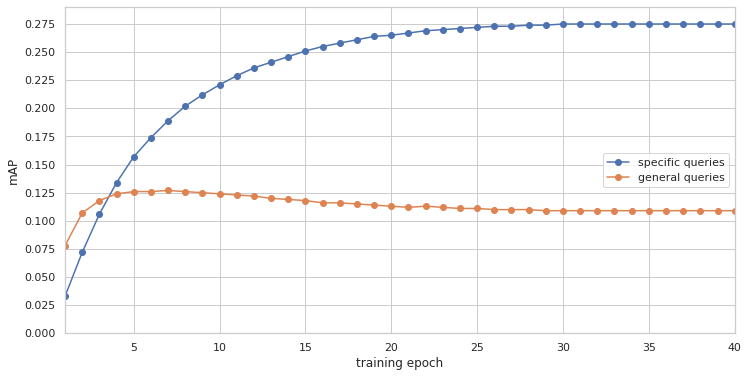

In [5]:
plot_data = sent2vec_epoch_results.xs('mAP', level=1, axis=1).xs('avg', level=1, axis=1)
err_data = sent2vec_epoch_results.xs('mAP', level=1, axis=1).xs('err', level=1, axis=1)
plot_data.index = range(1,41)
ax = plot_data.iloc[:,1].plot(label="specific queries", figsize=(12,6), style="-o", legend=True, xlim=(1,40), ylim=(0.0,0.29), yticks=np.arange(0,0.30,0.025))
ax = plot_data.iloc[:,0].plot(label="general queries", figsize=(12,6), style="-o", legend=True, xlim=(1,40), ylim=(0.0,0.29))
ax.set_ylabel("mAP");
ax.set_xlabel("training epoch")
ax.legend(loc="center right")
# plt.fill_between(plot_data.index, plot_data.iloc[:,1].values-err_data.iloc[:,1].values, plot_data.iloc[:,1].values+err_data.iloc[:,1].values,
#     alpha=0.4, edgecolor=sns.color_palette("Blues")[3], facecolor=sns.color_palette("Blues")[1], linewidth=1)
# plt.fill_between(plot_data.index, plot_data.iloc[:,0].values-err_data.iloc[:,0].values, plot_data.iloc[:,0].values+err_data.iloc[:,0].values,
#     alpha=0.4, edgecolor=sns.color_palette("Oranges")[3], facecolor=sns.color_palette("Oranges")[1], linewidth=1)
plt.savefig("images/sent2vec_epoch_search.pdf", transparent=True, bbox_inches="tight")

## Pseudo relevance feedback

In [5]:
prf_grid = [(150,200,np.round(i,3)) for i in np.linspace(0,1,21)]
search_prf_models = [(f"prf nrd={nrd:.2f} net={net:.2f} ew={ew:.2f}", 
                      PRFWrapper(Sent2VecRetrievalAlgorithm(f"../../data/models/sent2vec/wiki_bigrams.bin", False), nrd, net, ew),
                      papers_basic) for nrd, net, ew in prf_grid]

In [ ]:
search_prf_results = train_evaluate_models(search_prf_models, [general_keywords_val, specific_keywords_val], n_jobs=6)

In [ ]:
search_prf_results.to_csv("../../data/results/sent2vec_wiki_search_prf_results.csv")

In [9]:
search_prf_results = pd.read_csv("../../data/results/sent2vec_wiki_search_prf_results.csv", index_col=0, header=[0,1,2])

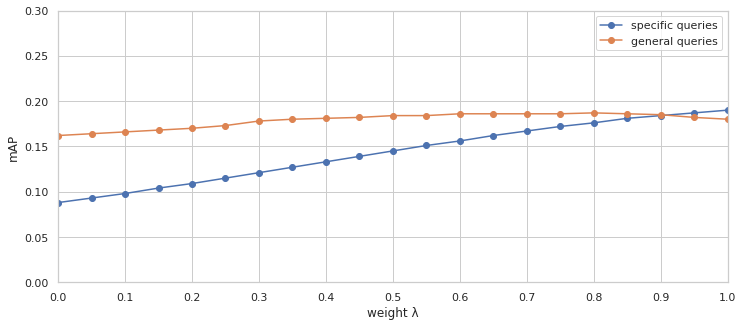

In [10]:
plot_data = search_prf_results.xs('mAP', level=1, axis=1).xs('avg', level=1, axis=1)
err_data = search_prf_results.xs('mAP', level=1, axis=1).xs('err', level=1, axis=1)
plot_data.index = np.linspace(0,1,21)
ax = plot_data.iloc[:,1].plot(label="specific queries", figsize=(12,5), style="-o", legend=True, xticks=[0]+np.linspace(0,1,11), xlim=(0,1),  ylim=(0.0,0.3))
ax = plot_data.iloc[:,0].plot(label="general queries", figsize=(12,5), style="-o", legend=True, xticks=[0]+np.linspace(0,1,11), xlim=(0,1),ylim=(0.0,0.3))
ax.set_ylabel("mAP");
ax.set_xlabel("weight λ")
# plt.fill_between(plot_data.index, plot_data.iloc[:,1].values-err_data.iloc[:,1].values, plot_data.iloc[:,1].values+err_data.iloc[:,1].values,
#     alpha=0.4, edgecolor=sns.color_palette("Blues")[3], facecolor=sns.color_palette("Blues")[1], linewidth=1)
# plt.fill_between(plot_data.index, plot_data.iloc[:,0].values-err_data.iloc[:,0].values, plot_data.iloc[:,0].values+err_data.iloc[:,0].values,
#     alpha=0.4, edgecolor=sns.color_palette("Oranges")[3], facecolor=sns.color_palette("Oranges")[1], linewidth=1)
plt.savefig("images/sent2vec_prf.pdf", transparent=True, bbox_inches="tight")

## Ontology query expansion

In [31]:
with open("../../data/keyword_hierarchy.json", 'r') as file:
    keyword_hierarchy = json.load(file)

In [8]:
oqe_grid = [np.round(i,3) for i in np.linspace(0,1,21)]
search_oqe_models = [(f"ontology expansion wrapper w={ew}", OntologyExpansionWrapper(Sent2VecRetrievalAlgorithm(f"../../data/models/sent2vec/wiki_bigrams.bin", False), keyword_hierarchy, True, ew), papers_basic) for ew in oqe_grid]

In [ ]:
search_oqe_results = train_evaluate_models(search_oqe_models, [general_keywords_val, specific_keywords_val], n_jobs=2)

In [ ]:
search_oqe_results.to_csv("../../data/results/sent2vec_wiki_search_oqe_results.csv")

In [7]:
search_oqe_results = pd.read_csv("../../data/results/sent2vec_wiki_search_oqe_results.csv", index_col=0, header=[0,1,2])

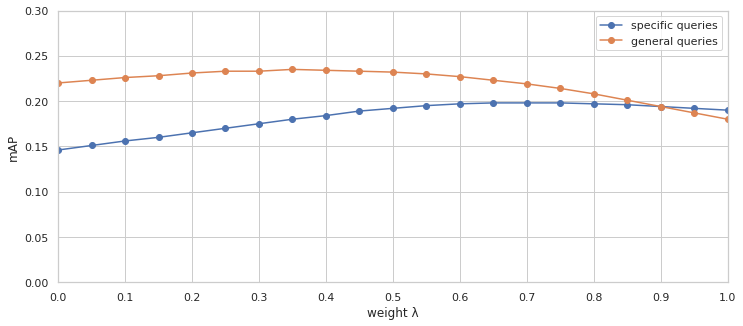

In [8]:
plot_data = search_oqe_results.xs('mAP', level=1, axis=1).xs('avg', level=1, axis=1)
err_data = search_oqe_results.xs('mAP', level=1, axis=1).xs('err', level=1, axis=1)
plot_data.index = np.linspace(0,1,21)
ax = plot_data.iloc[:,1].plot(label="specific queries", figsize=(12,5), style="-o", legend=True, xticks=[0]+np.linspace(0,1,11), xlim=(0,1), ylim=(0.0,0.3))
ax = plot_data.iloc[:,0].plot(label="general queries", figsize=(12,5), style="-o", legend=True, xticks=[0]+np.linspace(0,1,11), xlim=(0,1), ylim=(0.0,0.3))
ax.set_ylabel("mAP");
ax.set_xlabel("weight λ")
ax.legend(loc="upper right")
# plt.fill_between(plot_data.index, plot_data.iloc[:,1].values-err_data.iloc[:,1].values, plot_data.iloc[:,1].values+err_data.iloc[:,1].values,
#     alpha=0.4, edgecolor=sns.color_palette("Blues")[3], facecolor=sns.color_palette("Blues")[1], linewidth=1)
# plt.fill_between(plot_data.index, plot_data.iloc[:,0].values-err_data.iloc[:,0].values, plot_data.iloc[:,0].values+err_data.iloc[:,0].values,
#     alpha=0.4, edgecolor=sns.color_palette("Oranges")[3], facecolor=sns.color_palette("Oranges")[1], linewidth=1)
plt.savefig("images/sent2vec_oqe.pdf", transparent=True, bbox_inches="tight")

## Save best model

In [33]:
sent2vec_oqe_model = OntologyExpansionWrapper(Sent2VecRetrievalAlgorithm(f"../../data/models/sent2vec/wiki_bigrams.bin", False), keyword_hierarchy, True, 0.5)
sent2vec_oqe_model.prepare(papers_basic)
file_path = "../../data/models/sent2vec/sent2vec_oqe.model"
with open(file_path, "wb") as file:
    pickle.dump(sent2vec_oqe_model, file)